# Classification and Localization

* Object localization is about finding and marking where objects are in an image.

* Object localization can be framed as a **regression task** where the goal is to predict the **bounding box** of an object in an image.

* The bounding box is typically defined by **four coordinates**:
    1. The horizontal $(x)$ and vertical $(y)$ coordinates of the object's **center**.
    2. The **width** $(w)$ and **height** $(h)$ of the object.

* The model doesn't need significant modification; we only need to **add a second dense output** layer with **four units** (usually placed above the global average pooling layer), and it can be trained with **MSE** loss.

# Training a Localizer model

* **550** images of **flowers** from the **TDFS.flowers** dataset have been downloaded and processed using **VGG Image Annotator** for feature extraction. This dataset is used to train a model designed to detect the **location** of **flowers** within images. An **Xception-based architecture** has been employed as the backbone of the detection model. Xception, known for its efficiency and performance in image classification tasks, is leveraged to enhance the accuracy of flower location detection in the dataset.

## 0. Annotating Images

* If the dataset lacks **bounding boxes** around the objects, so we need to create them manually. 

* This **step** is often one of the **most challenging** and **expensive** aspects of a machine learning project—acquiring the labels. It's worthwhile to invest time in finding the right tools for this task.

* For **annotating images** with bounding boxes, open-source image labeling tools such as **VGG Image Annotator**, **LabelImg**, **OpenLabeler**, and **ImgLab** can be used.

## 1. Loading and Creating the Dataset

* We are working with a flowers dataset. A CSV file is also available, containing image paths and bounding box coordinates of the images.

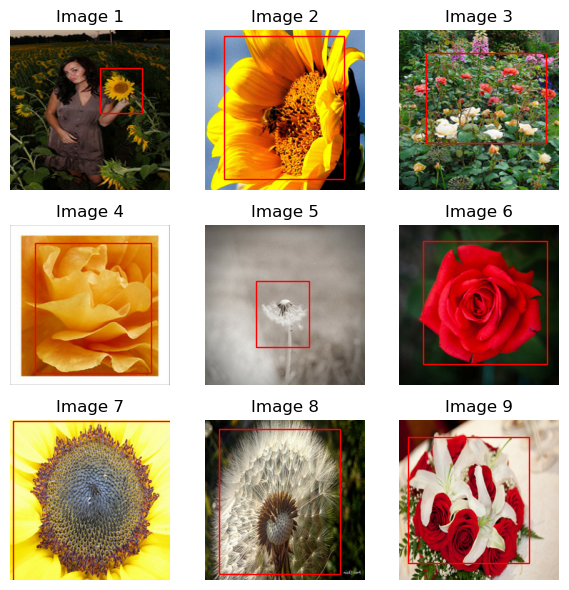

In [2]:
import os
import json
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Enable eager execution for TensorFlow
tf.compat.v1.enable_eager_execution()

# Define paths to your data
image_folder = 'flowers/flowers_images'  # Path to folder containing images
csv_file = 'flowers/flowers_csv.csv'     # Path to CSV file containing image metadata

# Desired image shape after resizing
IMG_SHAPE = (224, 224)

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_file)

# Function to extract bounding box coordinates from a JSON string
def extract_bbox(json_str):
    bbox = json.loads(json_str)  # Parse the JSON string into a dictionary
    x = bbox['x']
    y = bbox['y']
    width = bbox['width']
    height = bbox['height']
    return x, y, width, height

# Function to load images and their corresponding bounding boxes
def load_images(df, image_folder, target_size=(224, 224)):
    images = []
    labels = []
    
    for index, row in df.iterrows():
        image_name = row['filename']
        image_path = os.path.join(image_folder, image_name)
        
        # Parse the bounding box from the JSON string
        bbox_json = row['region_shape_attributes']
        x, y, w, h = extract_bbox(bbox_json) 
        
        # Load and resize the image
        img = Image.open(image_path)
        original_width, original_height = img.size 
        img = img.resize(target_size)
        img_array = np.array(img)  # Convert resized image to numpy array    
        
        # Scale the bounding box coordinates to match the resized image
        x_scale = target_size[0] / original_width
        y_scale = target_size[1] / original_height    
        x_new = int(x * x_scale)
        y_new = int(y * y_scale)
        w_new = int(w * x_scale)
        h_new = int(h * y_scale)      
        
        # Convert bounding box to numpy array and append to the labels list
        label_array = np.array((x_new, y_new, w_new, h_new))  
        images.append(img_array)
        labels.append(label_array)  
    
    return images, labels

# Load images and their corresponding bounding boxes
images, labels = load_images(df, image_folder, IMG_SHAPE)

# Convert lists of images and labels to numpy arrays
images_np = np.array(images)
labels_np = np.array(labels)

# Convert numpy arrays to TensorFlow datasets
img_dataset = tf.data.Dataset.from_tensor_slices(images_np)
labels_dataset = tf.data.Dataset.from_tensor_slices(labels_np)

# Combine images and labels into a single dataset
dataset = tf.data.Dataset.zip((img_dataset, labels_dataset))

# Optionally shuffle, batch, and prefetch the dataset
dataset = dataset.shuffle(buffer_size=len(images_np))  # Shuffle dataset
# dataset = dataset.batch(1)  # Batch size of 1 for individual image display (uncomment if needed)

# Function to plot images with bounding boxes
def plot_images_with_bboxes(dataset, num_images=9):
    plt.figure(figsize=(6, 6))  # Create a figure for a 3x3 grid of images

    for i, (img, label) in enumerate(dataset):
        if i >= num_images:  # Limit the number of images to display
            break

        # Convert tensors to numpy arrays
        img = img.numpy()
        label = label.numpy()
        x, y, w, h = label

        # Create a subplot for each image
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        
        # Add a bounding box
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none'))

        # Title and axis off
        plt.title(f"Image {i+1}")
        plt.axis('off')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Example usage of the plot function
plot_images_with_bboxes(dataset)


## 2. Dataset Splitting for Training, Validation, and Testing

In [3]:
from functools import partial
from tensorflow import keras

# Define the split ratios for training, validation, and testing datasets
train_ratio = 0.7  # Ratio of data used for training
valid_ratio = 0.15 # Ratio of data used for validation
test_ratio = 0.15  # Ratio of data used for testing

# Calculate the sizes of each split based on the total number of samples
total_size = len(images_np)  # Total number of samples in the dataset
train_size = int(train_ratio * total_size)  # Number of samples allocated for training
valid_size = int(valid_ratio * total_size)  # Number of samples allocated for validation
test_size = total_size - train_size - valid_size  # Number of samples allocated for testing

# Split the dataset into training, validation, and testing sets
train_set_raw = dataset.take(train_size)  # Select the first `train_size` samples for training
remaining_dataset = dataset.skip(train_size)  # Skip the first `train_size` samples to process the remaining dataset
valid_set_raw = remaining_dataset.take(valid_size)  # Select the next `valid_size` samples for validation
test_set_raw = remaining_dataset.skip(valid_size)  # Skip the next `valid_size` samples to obtain the testing set

# Set the batch size and repeat count for data processing
batch_size = 16  # Number of samples per batch
repeat_count = 20  # Number of times the dataset will be repeated

# Prepare the training dataset with batching, repeating, and prefetching
train_set = train_set_raw.batch(batch_size).repeat(repeat_count).prefetch(1)

# Prepare the validation dataset with batching, repeating, and prefetching
valid_set = valid_set_raw.batch(batch_size).repeat(repeat_count).prefetch(1)

# Prepare the testing dataset with batching, repeating, and prefetching
test_set = test_set_raw.batch(batch_size).repeat(repeat_count).prefetch(1)

## 3. Building a Custom Model with Xception Base and Bounding Box Output

In [4]:
from tensorflow import keras

# Define the base model using Xception architecture with pre-trained ImageNet weights
base_model = keras.applications.xception.Xception(
    weights="imagenet",  # Use pre-trained weights from ImageNet
    include_top=False,   # Exclude the fully connected layers at the top
    input_shape=IMG_SHAPE + (3,)  # Define input shape (height, width, channels)
)

# Add a Global Average Pooling layer to reduce the spatial dimensions of the feature maps
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

# Add a Dense layer to output bounding box coordinates
loc_output = keras.layers.Dense(4)(avg)  # Output layer for bounding box coordinates (x, y, width, height)

# Define the final model with base model input and the custom output layer
model = keras.models.Model(
    inputs=base_model.input,  # Input to the model
    outputs=[loc_output]  # Output of the model
)

# Print a summary of the model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

## 4. Compiling and Training the Model with Custom Optimizer and Hyperparameters

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow import keras

# Define the optimizer with specific hyperparameters
# SGD (Stochastic Gradient Descent) is used here with a learning rate, momentum, and decay.
# You may need to adjust these parameters based on your specific needs and experiment for optimal performance.
optimizer = keras.optimizers.SGD(
    learning_rate=0.8e-2,  # Learning rate for updating model weights
    momentum=0.9,         # Momentum factor for smoothing the updates
    decay=0.01            # Decay factor for the learning rate over time
)

# Compile the model with mean squared error loss and the defined optimizer
# Metrics include accuracy to monitor during training, but note that accuracy might not be the best metric for regression tasks.
model.compile(
    loss="mse",           # Mean Squared Error loss function
    optimizer=optimizer,  # Optimizer defined above
    metrics=["accuracy"]  # Metrics to track during training
)

# Train the model using the training and validation datasets
# Steps per epoch and validation steps are set based on a fraction of the total dataset size.
# The model will be trained for 20 epochs; you can adjust this number as needed based on model performance and convergence.
history = model.fit(
    train_set,  # Training dataset
    steps_per_epoch=int(0.7 * total_size / batch_size),  # Number of steps per epoch, based on a fraction of the dataset
    validation_data=valid_set,  # Validation dataset
    validation_steps=int(0.15 * total_size / batch_size),  # Number of validation steps, based on a fraction of the dataset
    epochs=20  # Number of epochs for training
)

Epoch 1/20
24/24 [==============================] - 119s 5s/step - loss: 11650.0736 - acc: 0.5026 - val_loss: 411146586937442096375768179101663232.0000 - val_acc: 0.0250
Epoch 2/20
24/24 [==============================] - 96s 4s/step - loss: nan - acc: 0.0650 - val_loss: nan - val_acc: 0.0875
Epoch 3/20
 8/24 [=========>....................] - ETA: 55s - loss: nan - acc: 0.0088

KeyboardInterrupt: 

## 5. Evaluating and Visualizing Model Predictions on the Test Set

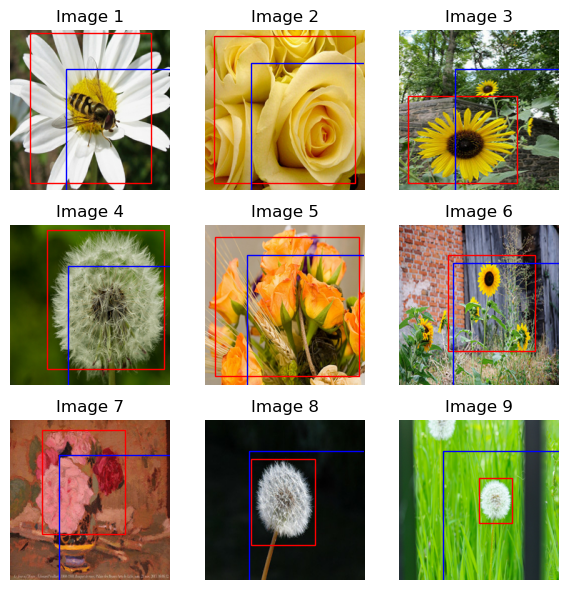

In [23]:
# Evaluate the model on the test set to get the final performance metrics
test_loss, test_accuracy = model.evaluate(test_set)

print(f"Test Loss: {test_loss}")       # Print the loss on the test set
print(f"Test Accuracy: {test_accuracy}")  # Print the accuracy on the test set

# Make predictions on the test set
predictions = model.predict(test_set)

# Plot the results for visual inspection
plt.figure(figsize=(6, 6))  # Create a figure with a 6x6 size for a 3x3 grid of images

# Iterate over one batch of test images and their corresponding labels
for img, label in test_set.take(1):  # Take one batch of test data
    # Iterate through the first 9 images in the batch
    for i in range(9):
        Img = img[i].numpy()  # Convert the image tensor to a numpy array
        Label_true = label[i].numpy()  # Convert the true bounding box coordinates to a numpy array
        Label_predict = predictions[i]  # Get the predicted bounding box coordinates

        # Extract coordinates for the true and predicted bounding boxes
        x, y, w, h = Label_true
        X, Y, W, H = Label_predict

        # Create a subplot for each image in a 3x3 grid
        plt.subplot(3, 3, i + 1)
        plt.imshow(Img)  # Display the image
        
        # Add the true bounding box in red
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none'))
        
        # Add the predicted bounding box in blue
        plt.gca().add_patch(plt.Rectangle((X, Y), W, H, edgecolor='blue', facecolor='none'))
        
        # Set title and hide the axis
        plt.title(f"Image {i+1}")
        plt.axis('off')

# Adjust layout to prevent overlapping and display the plots
plt.tight_layout()
plt.show()